In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_parquet(path="../../../workspaces/data/green_tripdata_2021-01.parquet")

In [3]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [4]:
data.lpep_dropoff_datetime = pd.to_datetime(data.lpep_dropoff_datetime)
data.lpep_pickup_datetime = pd.to_datetime(data.lpep_pickup_datetime)
data["duration"] = (data.lpep_dropoff_datetime - data.lpep_pickup_datetime)
data.duration = data.duration.apply(lambda d: d.seconds / 60)

In [5]:
data.duration.describe(percentiles=[0.5, 0.75, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
75%         23.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [6]:
data_subset = data[(data.duration >= 1) & (data.duration <= 68)]
data_subset.shape[0]/data.shape[0]

0.9714707650487467

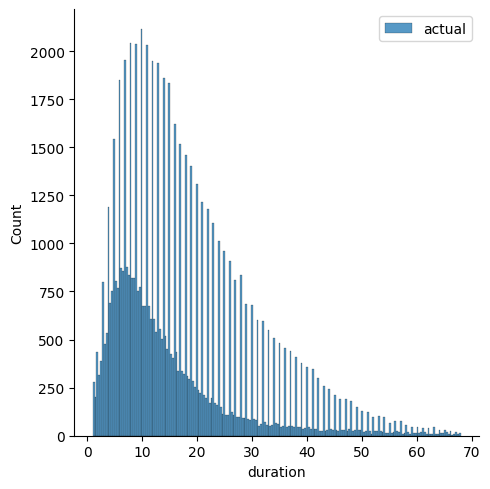

In [7]:
sns.displot(data_subset.duration, label="actual", bins=200)
plt.legend()

In [8]:
data_subset["is_toll_taken"] = (data_subset["tolls_amount"] > 0).astype(int)
data_subset["is_trip_type_missing"] = (data_subset["trip_type"].isna()).astype(int)
data_subset["is_congested"] = (data_subset["congestion_surcharge"] > 0).astype(int)
data_subset["is_congestion_missing"] = (data_subset["congestion_surcharge"].isna()).astype(int)
data_subset["is_payment_type_missing"] = (data_subset["payment_type"].isna()).astype(int)
data_subset["congestion_surcharge"] = data_subset["congestion_surcharge"].fillna(0)

/tmp/ipykernel_38793/3865844338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset["is_toll_taken"] = (data_subset["tolls_amount"] > 0).astype(int)
/tmp/ipykernel_38793/3865844338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset["is_trip_type_missing"] = (data_subset["trip_type"].isna()).astype(int)
/tmp/ipykernel_38793/3865844338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [8]:
categorical_columns = ["PULocationID", "DOLocationID"]

In [9]:
numerical_columns = ["trip_distance",
                     "tolls_amount",
                     "congestion_surcharge",
                     "is_toll_taken",
                     "is_congested",
                     "is_trip_type_missing",
                     "is_payment_type_missing",
                     "is_congestion_missing"]

In [10]:
target_column = "duration"

In [11]:
data_subset[categorical_columns] = data_subset[categorical_columns].astype(str)

/tmp/ipykernel_9374/3079424306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[categorical_columns] = data_subset[categorical_columns].astype(str)


In [25]:
def get_data(file_location: str, file_type: str="parquet"):
    if file_type in ["parquet", "csv"]:
        if file_type == "parquet":
            data = pd.read_parquet(f"{file_location}.{file_type}")
        elif file_type == "csv":
            data = pd.read_csv(f"{file_location}.{file_type}", encoding='utf-8', sep=",")
        return data
    else:
        raise NameError()
    
def get_datetime_features(data, date_column: str):
    data = data.copy()
    data["dt_day_of_week"] = [date.weekday() for date in data[date_column]]
    data["dt_hour_of_day"] = data[date_column].dt.hour
    data["dt_is_weekend"] = [1 if day in [5,6] else 0 for day in data["dt_day_of_week"]]
    data["dt_is_night"] = [1 if hr >= 18 or hr <= 5 else 0 for hr in data["dt_hour_of_day"]]
    return data


def preprocess_data(data):
    data = data.copy()
    data.lpep_dropoff_datetime = pd.to_datetime(data.lpep_dropoff_datetime)
    data.lpep_pickup_datetime = pd.to_datetime(data.lpep_pickup_datetime)
    data["duration"] = (data.lpep_dropoff_datetime - data.lpep_pickup_datetime)
    data.duration = data.duration.apply(lambda d: d.seconds / 60)
    
    data_subset = data[(data.duration >= 1) & (data.duration <= 68)].copy()
    data_subset["is_toll_taken"] = (data_subset["tolls_amount"] > 0).astype(int)
    data_subset["is_trip_type_missing"] = (data_subset["trip_type"].isna()).astype(int)
    data_subset["is_congested"] = (data_subset["congestion_surcharge"] > 0).astype(int)
    data_subset["is_congestion_missing"] = (data_subset["congestion_surcharge"].isna()).astype(int)
    data_subset["is_payment_type_missing"] = (data_subset["payment_type"].isna()).astype(int)
    data_subset["congestion_surcharge"] = data_subset["congestion_surcharge"].fillna(0)
    data_subset["PU_DO"] = data_subset["PULocationID"].astype(str) + '_' + data_subset["DOLocationID"].astype(str)

    data_subset = get_datetime_features(data_subset, "lpep_pickup_datetime")
    
    categorical_columns = ["PU_DO"]
    numerical_columns = ["trip_distance",
                     "tolls_amount",
                     "congestion_surcharge",
                     "is_toll_taken",
                     "is_congested",
                     "is_trip_type_missing",
                     "is_payment_type_missing",
                     "is_congestion_missing"]
    date_feature_columns = [col for col in data_subset if col.split("_")[0] == "dt"]
    target = "duration"

    preprocessed_data = data_subset[categorical_columns + numerical_columns + date_feature_columns + [target]]

    return preprocessed_data

In [53]:
data = get_data(file_location="../../../workspaces/data/green_tripdata_2021-01", file_type="parquet")
val_data = get_data(file_location="../../../workspaces/data/green_tripdata_2021-02")

In [54]:
preprocessed_data = preprocess_data(data)
val_preprocessed_data = preprocess_data(val_data)

In [28]:
target = "duration"

In [55]:
X = preprocessed_data[[cols for cols in preprocessed_data if target != cols]].copy()
y = preprocessed_data[target].copy()

X_val = val_preprocessed_data[[cols for cols in val_preprocessed_data if target != cols]].copy()
y_val = val_preprocessed_data[target].copy()

In [56]:
X_train_records = X.to_dict(orient="records")
X_val_records = X_val.to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(X_train_records)
X_val = dv.transform(X_val_records)

In [40]:
model = RFR(n_jobs=4, random_state=42).fit(X_train,y)
y_predict = model.predict(X_train)

In [57]:
y_val_predict = model.predict(X_val)

/tmp/ipykernel_9374/394742614.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, label="true")
/tmp/ipykernel_9374/394742614.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_predict,label="predictions")
/tmp/ipykernel_9374/394742614.py:3: UserWarning: 

`distplot` is a deprecated functi

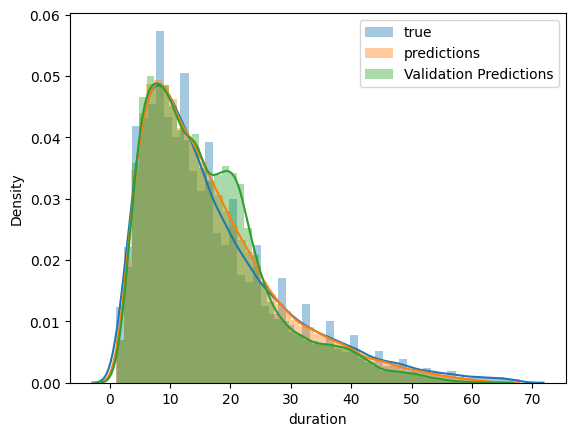

In [59]:
sns.distplot(y, label="true")
sns.distplot(y_predict,label="predictions")
sns.distplot(y_val_predict, label="Validation Predictions")

plt.legend()

In [60]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [48]:
train_rmse = root_mean_squared_error(y, y_predict)
val_rmse = root_mean_squared_error(y_val, y_val_predict)
print(f"Train rmse: {train_rmse}, val rmse: {val_rmse}")

2.1300329534972517